In [243]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import wasabi
import seaborn as sns
import math
pd.set_option('display.max_rows',4000)
import re
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '/home/shan/4th Sem/CH5019/Term project 2020/covid19-in-india'

In [4]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object or dataset.dtypes[column] == '<M8[ns]':
            g = sns.countplot(x=dataset[column]) #rder=dataset[column].value_counts().index)
            substrings = [s.get_text()[:18] for s in g.get_xticklabels()]
            g.set(xticklabels=substrings)
            plt.yticks(rotation=0)
            plt.xticks(rotation=90)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=0)

# Dataset

In [5]:
ind = pd.read_csv(path+'/IndividualDetails.csv', index_col='id',parse_dates=True)
print(ind.shape)
ind.name='ind'

ind['diagnosed_date'] = pd.to_datetime(ind['diagnosed_date'],dayfirst=True )
ind['status_change_date'] = pd.to_datetime(ind['status_change_date'], dayfirst=True)
ind.dtypes

(18032, 10)


government_id                 object
diagnosed_date        datetime64[ns]
age                           object
gender                        object
detected_city                 object
detected_district             object
detected_state                object
nationality                   object
status_change_date    datetime64[ns]
notes                         object
dtype: object

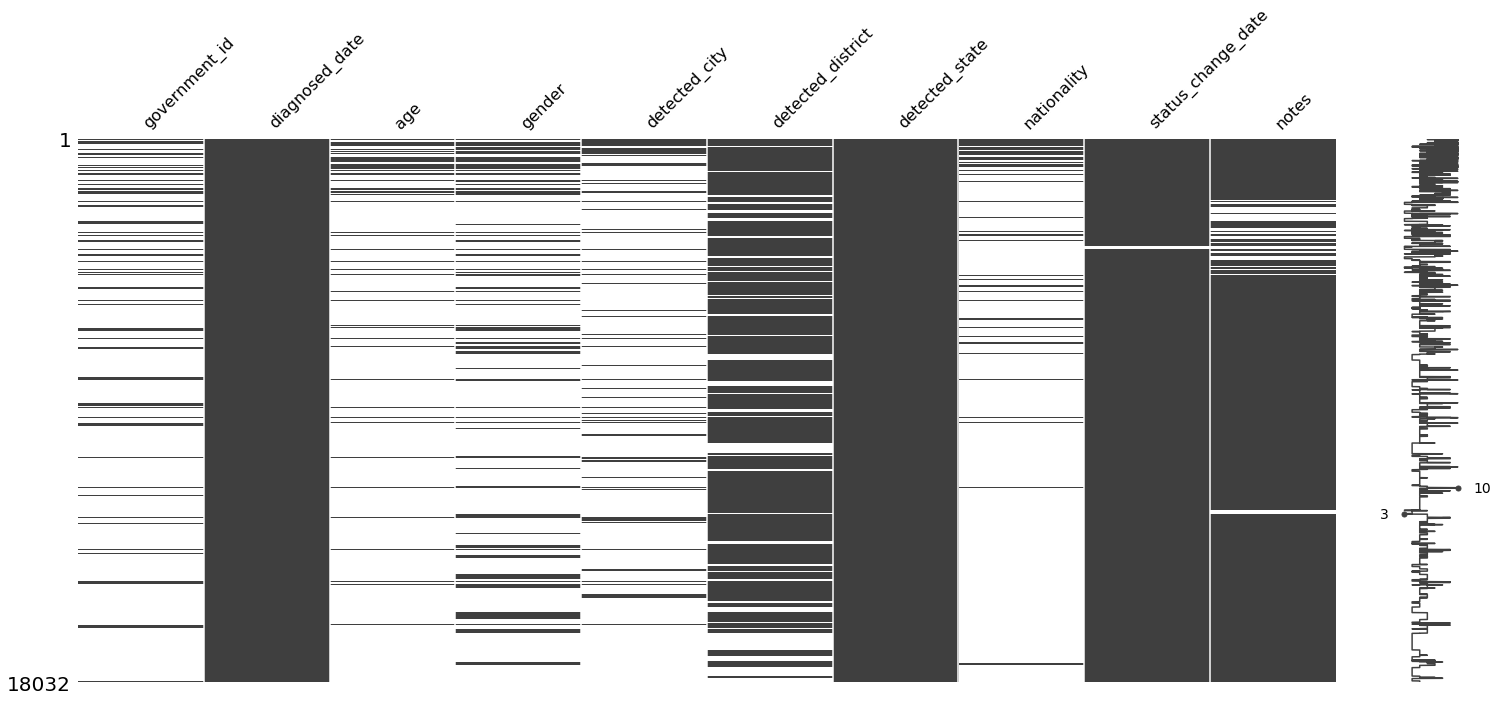

In [6]:
missingno.matrix(ind)

In [7]:
#### Percentage of missing values
ind.isna().sum()/ind.shape[0]*100

government_id         86.035936
diagnosed_date         0.000000
age                   90.572316
gender                78.460515
detected_city         88.004658
detected_district     18.622449
detected_state         0.000000
nationality           91.082520
status_change_date     0.610027
notes                  7.309228
dtype: float64

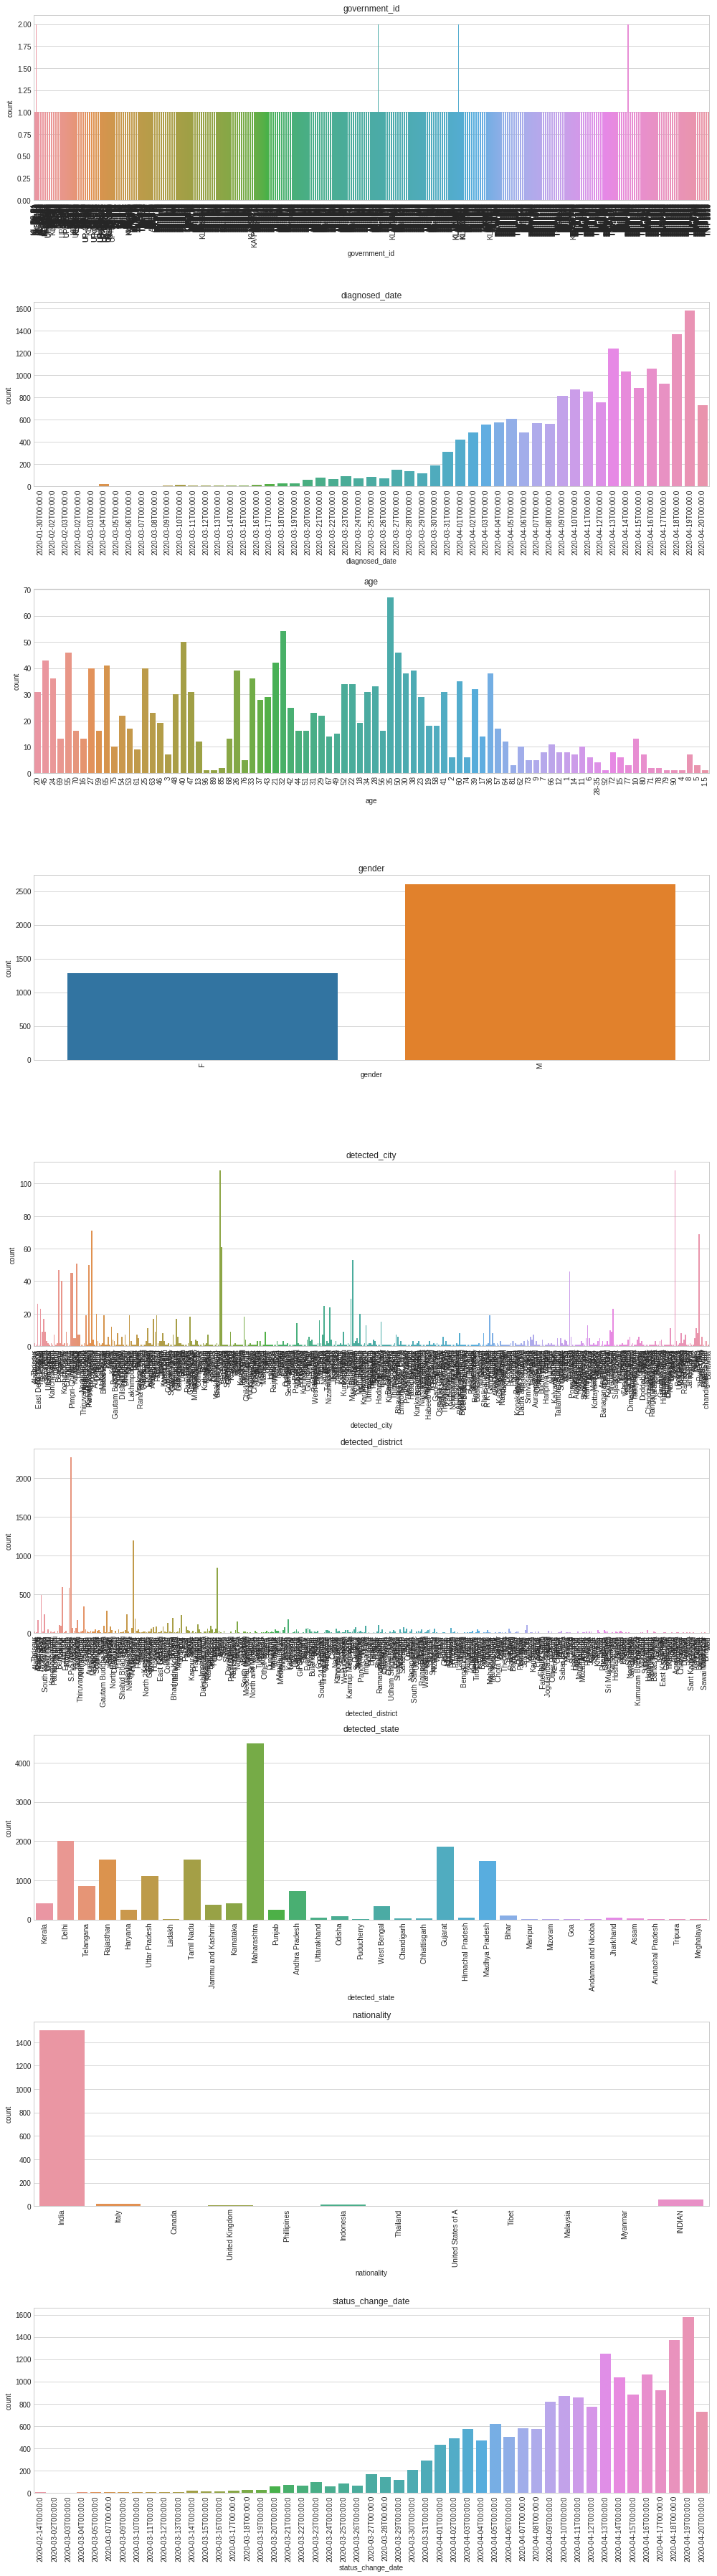

In [8]:
plot_distribution(ind.iloc[:,:-1], cols=1,width=14,height=50)
plt.tight_layout()

In [9]:
ind.head()

,government_id,diagnosed_date,age,gender,detected_city,detected_district,detected_state,nationality,status_change_date,notes
id,,,,,,,,,,
0,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,India,2020-02-14,Travelled from Wuhan
1,KL-AL-P1,2020-02-02,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,2020-02-14,Travelled from Wuhan
2,KL-KS-P1,2020-02-03,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,2020-02-14,Travelled from Wuhan
3,DL-P1,2020-03-02,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,2020-03-15,"Travelled from Austria, Italy"
4,TS-P1,2020-03-02,24,M,Hyderabad,Hyderabad,Telangana,India,2020-03-02,"Travelled from Dubai to Bangalore on 20th Feb,..."


In [173]:
ind=ind.set_index('diagnosed_date')
print(ind.loc[:'2020-04-14',:].shape)
ind=ind.reset_index()

(11484, 9)


<font face = "Courier New" size = "3" color=Blue> 
- No new cases diagnosed/recorded from 4th April-10th April
- To fill missing values, we use distribution of existing values in that column
- Later on, we must check for disparity between notes and age etc, manually
</font>


# Analysing individual people

<font face = "Courier New" size = "3" color=Blue> 
- This can help us identify people with travel history 
</font>


# Cleaning the Data

<font face = "Courier New" size = "3" color=Blue> 
- Wherever applicable we can fill missing values using the distribution of that column - example: age, gender*, notes
- We can groupby the state and then fill missing values according to the distribution of the column for that state - example: detected_district (detected_state), detected_city(detected_district), nationality(detected_state), gender* 
- We must manually set NaNs in notes to details awaited since we do not know anything about them
- We must manually set the district, city etc. of cases that are contact cases with some govt id
</font>


In [177]:
notes=clean_ind.notes.unique()

re.findall(combined_contact,'contact no familyyy Travelled history of P223 Germany',re.I|re.MULTILINE)

# related, relative, family, hospital, conference, patient,mother,contracted,id, not second,Nizamuddin-> contact
# indonesia,iran,airport -> travel
contact=['contact','related', 'relative', 'family', 'hospital','conference','nizamuddin','P-{0,1}[0-9]{1,4}']
travel = ['travel,''indonesia','airport']
combined_contact = "(" + ")|(".join(contact) + ")"
combined_travel = "(" + ")|(".join(travel) + ")"

#if re.match(combined, mystring):

travel=[]
contact = []
for i in notes:
    if (re.findall(combined_contact,i,re.I|re.MULTILINE)and not re.findall(r'second',i,re.I|re.MULTILINE):
        contact.append(i)
    elif re.findall(combined_travel,i,re.I|re.MULTILINE) and not re.findall(r' no ',i,re.I|re.MULTILINE):
        travel.append(i)
        

In [15]:
## we will split each of the dataframes into state groups, replace them inplace and then combine them

In [16]:
kerala=ind.groupby('detected_state',sort=False).get_group('Kerala')
kerala.isna().sum()

diagnosed_date          0
government_id         352
age                   271
gender                286
detected_city         316
detected_district       0
detected_state          0
nationality           200
status_change_date      0
notes                  18
dtype: int64

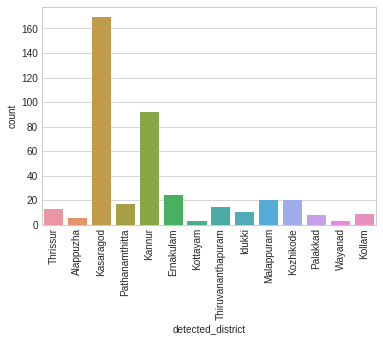

In [17]:
ax=sns.countplot(x='detected_district',data=kerala)
plt.xticks(rotation=90)
plt.show()

In [18]:
# replacing gender age, gender,detected_state according to state
# Age
def fill_col(data,column='age'):
    s = data[column].value_counts(normalize=True)
    missing = data[column].isnull()
    try:
        data.loc[missing,column] = np.random.choice(s.index, size=len(data[missing]),p=s.values)
    except:
        pass

In [19]:
#kerala.age.fillna(pd.Series(np.random.choice(s.index, size=len(kerala[missing]),p=s.values)),inplace=True)

In [20]:
fill_col(kerala,'gender')

/home/shan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [21]:
kerala.isna().sum()

diagnosed_date          0
government_id         352
age                   271
gender                  0
detected_city         316
detected_district       0
detected_state          0
nationality           200
status_change_date      0
notes                  18
dtype: int64

In [22]:
ind.groupby(['detected_state','detected_district']).groups

{('Kerala',
  'Thrissur'): Int64Index([0, 75, 468, 713, 714, 806, 1071, 1450, 1887, 1888, 2214, 2858,
             5548],
            dtype='int64'),
 ('Kerala',
  'Alappuzha'): Int64Index([1, 552, 3459, 5544, 5545], dtype='int64'),
 ('Kerala',
  'Kasaragod'): Int64Index([    2,   116,   182,   238,   239,   240,   241,   242,   243,
               314,
             ...
              6282,  6283,  6989,  6990,  6991,  7892,  7893, 10889, 12966,
             16135],
            dtype='int64', length=169),
 ('Delhi', 'East Delhi'): Int64Index([3], dtype='int64'),
 ('Telangana',
  'Hyderabad'): Int64Index([    4,   106,   111,   126,   140,   148,   162,   163,   164,
               165,
             ...
             17113, 17114, 17115, 17116, 17117, 17118, 17119, 17120, 17121,
             17122],
            dtype='int64', length=486),
 ('Rajasthan', 'Italians*'): Int64Index([5, 20], dtype='int64'),
 ('Haryana',
  'Italians*'): Int64Index([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18

In [23]:
##filling detected_state
dict1={}
for i in ind.groupby(['detected_state'],sort=False).groups:
    data = ind.groupby(['detected_state'],sort=False).get_group(i)
    fill_col(data,'gender')
    fill_col(data,'age')
    fill_col(data,'detected_district')
    dict1[i] = data

In [24]:
for i in dict1:
    print(i)
    print(dict1[i][['age','gender','detected_district']].isna().sum())
    print()

Kerala
age                  0
gender               0
detected_district    0
dtype: int64

Delhi
age                  0
gender               0
detected_district    0
dtype: int64

Telangana
age                  0
gender               0
detected_district    0
dtype: int64

Rajasthan
age                  0
gender               0
detected_district    0
dtype: int64

Haryana
age                  0
gender               0
detected_district    0
dtype: int64

Uttar Pradesh
age                  0
gender               0
detected_district    0
dtype: int64

Ladakh
age                  0
gender               0
detected_district    0
dtype: int64

Tamil Nadu
age                  0
gender               0
detected_district    0
dtype: int64

Jammu and Kashmir
age                  0
gender               0
detected_district    0
dtype: int64

Karnataka
age                  0
gender               0
detected_district    0
dtype: int64

Maharashtra
age                  0
gender               0
detected_di

<font face = "Courier New" size = "3" color=Blue> 
- We notice that even after filling the columns, Arunachal Pradesh has missing value, for gender and age
- Since the mode gender is Male and mode age is 35, we fill that in
</font>


In [25]:
dict1['Arunachal Pradesh'].age=35
dict1['Arunachal Pradesh'].gender='M'
dict1['Arunachal Pradesh'].detected_city='Lohit'

/home/shan/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [26]:
df=pd.concat(dict1.values(), ignore_index=True)

In [27]:
## filling detected_city
dict2={}
for i in df.groupby(['detected_state','detected_district']).groups:
    data = df.groupby(['detected_state','detected_district']).get_group(i)
    fill_col(data,'detected_city')
    dict2[i] = data

In [28]:
for i in dict2:
    print(i)
    print(dict2[i][['age','gender','detected_district','detected_city']].isna().sum()/dict2[i].shape[0]*100)
    print()

('Andaman and Nicobar Islands', 'North and Middle Andaman')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Andaman and Nicobar Islands', 'South Andaman')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Andhra Pradesh', 'Anantapur')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Andhra Pradesh', 'Chittoor')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Andhra Pradesh', 'East Godavari')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Andhra Pradesh', 'Guntur')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Andhra Pradesh', 'Krishna')
age                  0.0
gend

dtype: float64

('Haryana', 'Sirsa')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Haryana', 'Sonipat')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Haryana', 'Yamunanagar')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Himachal Pradesh', 'Chamba')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Himachal Pradesh', 'Kangra')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Himachal Pradesh', 'Sirmaur')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Himachal Pradesh', 'Solan')
age                    0.0
gender                 0.0
detected_distri

dtype: float64

('Maharashtra', 'Buldana')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Maharashtra', 'Chandrapur')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Maharashtra', 'Dhule')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Maharashtra', 'Gondiya')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Maharashtra', 'Hingoli')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Maharashtra', 'Jalgaon')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Maharashtra', 'Jalna')
age                    0.0
gender                 0.0
detected_distr

age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Tamil Nadu', 'Nagapattinam')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Tamil Nadu', 'Namakkal')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Tamil Nadu', 'Perambalur')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Tamil Nadu', 'Ramanathapuram')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Tamil Nadu', 'Ranipet')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Tamil Nadu', 'Salem')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        

age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('West Bengal', 'Kolkata')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('West Bengal', 'Medinipur East')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('West Bengal', 'Nadia')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('West Bengal', 'North 24 Parganas')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('West Bengal', 'South 24 Parganas')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64



<font face = "Courier New" size = "3" color=Blue> 
- We notice that even after filling the columns, some districts have no detected city assigned
- In such cases, we will fill the same value in detected_city as detected_district
</font>


In [29]:
clean_ind=pd.concat(dict2.values(), ignore_index=True)

In [30]:
clean_ind.detected_city.fillna(clean_ind.detected_district,inplace=True)

In [31]:
clean_ind.isna().sum()/clean_ind.shape[0]*100

diagnosed_date         0.000000
government_id         86.035936
age                    0.000000
gender                 0.000000
detected_city          0.000000
detected_district      0.000000
detected_state         0.000000
nationality           91.082520
status_change_date     0.610027
notes                  7.309228
dtype: float64

In [32]:
clean_ind.nationality.fillna('India',inplace=True)

In [33]:
clean_ind['nationality'].replace('INDIAN', 'India',inplace=True)

In [34]:
clean_ind.notes.fillna('Details Awaited',inplace=True)
clean_ind.notes.replace('Details awaited', 'Details Awaited',inplace=True)

In [35]:
clean_ind = clean_ind.drop('government_id',axis=1)

In [49]:
clean_ind.sort_values(by='diagnosed_date',inplace=True)

<font face = "Courier New" size = "4" color=Maroon> 
SUMMARY
</font>
<font face = "Courier New" size = "3" color=Blue> 
- There are no missing States values
- For each state, there are some districts mentioned and others are null values. The districts are filled in according to the existing distribution of districts for each state. Gender and Age are also filled this way. 
- Even after doing this, Arunachal Pradesh had a district with only one case with no age, gender. Thus was impited with the mode of the overall data
-After this, cities were filled in according to the distribution of cities in each district.
-Even after this, there were districts that had no cities filled in them. For these cases, the city was set as the district
- Nationality was assumed to be Indian for those cases where not mentioned. Variations of the same nationality were standardised. Eg. Indian to India
- Notes that were not mentioned have been set as 'Details Awaited'
</font>


# Analysing Individual People

In [50]:
pd.DataFrame(clean_ind.notes.value_counts()).reset_index()

,index,notes
0,Details Awaited,15289
1,Travelled to Delhi,863
2,Travelled from Dubai,99
3,Local Transmission,92
4,Contact of Positive case,35
5,Travelled from UK,26
6,Have identified contact history,26
7,"Travelled from Dubai, UAE",25
8,Contact transmission,23
9,Travelled from Delhi,23


In [328]:
clean_ind.reset_index(inplace=True)
notes=clean_ind['notes'].unique()

In [329]:
# related, relative, family, hospital, conference, patient,mother,contracted,id, not second,Nizamuddin-> contact
# indonesia,iran,airport -> travel
contact=['contact','related', 'relative', 'family','conference','nizamuddin','P-{0,1}[0-9]{1,4}']
travel = ['travel','indonesia','airport']
no_contact = ['second','travel','local',' no ']
combined_contact = "(" + ")|(".join(contact) + ")"
combined_travel = "(" + ")|(".join(travel) + ")"
combined_no_contact =  "(" + ")|(".join(no_contact) + ")"
#if re.match(combined, mystring):

In [330]:
re.findall(r'(^no | no |sibling)','Siblings (7 years old and 8 months old)- grandchildren of a confirmedcontactno no familyyy Travelled history of P223 Germany',re.I|re.MULTILINE)

['Sibling', ' no ']

In [331]:
travel=[]
contact = []
for i in notes:
    if re.findall(combined_contact,i,re.I) and not re.findall(combined_no_contact,i,re.I):
        contact.append(i)
    elif re.findall(combined_travel,i,re.I) and not re.findall(r'(^no | no |sibling)',i,re.I):
        travel.append(i)
    else:
        pass
        

In [332]:
len(contact)

336

In [333]:
len(travel)

360

In [334]:
s='Siblings (7 years old and 8 months old)- grandchildren of a confirmed case from Srinagar with travel history to Saudi Arabia who had tested positive on 24th'
contact.append(s)

In [335]:
clean_ind['case']='Tertiary'

In [336]:
clean_ind.set_index('notes',inplace=True)
clean_ind.loc[travel,'case']='Primary'
clean_ind.loc[contact,'case']='Secondary'
clean_ind.reset_index(inplace=True)

In [338]:
clean_ind.case.value_counts()

Tertiary     15672
Primary       1567
Secondary      793
Name: case, dtype: int64

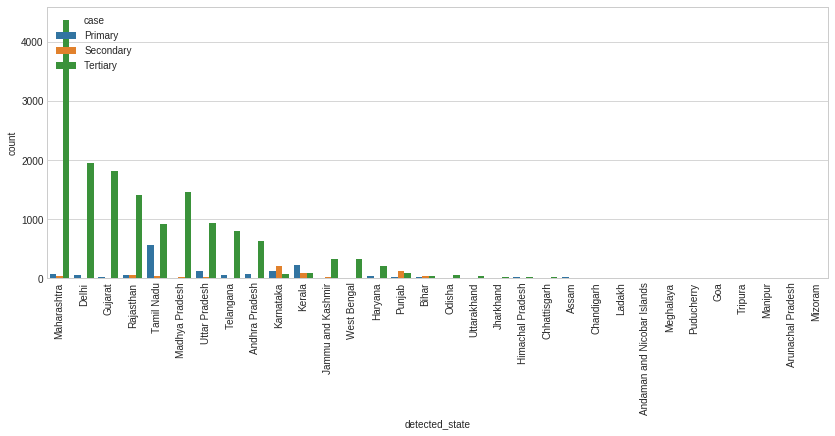

In [343]:
plt.figure(figsize=(14,5))
plt.style.use('seaborn-whitegrid')
sns.countplot(x='detected_state',data=clean_ind,hue='case', order=clean_ind.detected_state.value_counts().index)
plt.xticks(rotation=90)
plt.show()


# Only positive cases
<font face = "Courier New" size = "3" color=Blue> 
- Status change is assumed to be the column whose date is updated when the patient recovers or dies, else it is same as the diagnosed date
- It may happen that the patient dies on the day of being diagnosed but those cases are not considered
</font>


In [61]:
clean_ind.status_change_date.fillna(clean_ind.diagnosed_date,inplace=True)

In [344]:
contact

['Family members of P4',
 'Relative and neighbour of P35-P37',
 'Relative  and neighbour of P35-P37',
 'Was in contact with P22-P27',
 'Factory Manager contact with businessman from Italy',
 'Mother of P36',
 'Daughter of P44 & P45',
 'Friends of P35, P36, P37',
 'Father of P36',
 'Co-passenger with P44 & P45 in cab of P62 from Mumbai airport to Pune',
 'Cab driver who ferried P44, P45, P61 from Mumbai airport to Pune',
 'Mother of P43',
 'Daughter of P36 & P37',
 'Son in law of P36 & P37',
 'Daughter of P51 and P52',
 'Father of P43',
 'Wife of P51',
 'Mother of P64',
 'Son of P30',
 'Close contact of P41',
 'Wife of P73',
 'Friend of P78',
 'Wife of P78',
 'Wife of P77',
 'First contacts or family members of the group of 40 who came back from Dubai earlier',
 'Daughter of P74',
 'Spouse of P95, From Kalyan',
 '3 year old from Kalyan, Father P95 /Mother P122',
 'Doctor of P74',
 'Wife of P153',
 'Residing at N Ward,Close contact of P138',
 'Relative of P117',
 'Brother of P157',
 'Bro

In [93]:
clean_ind['label']=np.nan

In [100]:
clean_ind.loc[clean_ind.status_change_date<clean_ind.diagnosed_date].shape

(60, 10)

In [94]:
clean_ind.loc[clean_ind.status_change_date<=clean_ind.diagnosed_date,'label']='Positive'

In [95]:
clean_ind.label.fillna('Recovered/Dead',inplace=True)

In [97]:
clean_ind.label.value_counts()

Positive          17841
Recovered/Dead      191
Name: label, dtype: int64

<font face = "Courier New" size = "3" color=Blue> 
- There are may dates missing in this data - 
</font>


# Plotting

1. Which age group is the most infected?
2. Plot graphs of the cases observed, recovered, deaths per day country-wise and state-
wise.
3. Identify the positive cases on a state level. Quantify the intensity of virus spread for
each state.*
Intensity here means number of positive cases/population density.
4. List places in the country which are active hotspots/clusters as on 10.04.2020.*
Hotspot is defined as an area in a city where 10 or more people have been tested
positive.
5. Which states have the maximum change (consider increase and decrease separately)
in number of hotspots on weekly basis from 20.03.2020 to 10.04.2020 (3 weeks).
6. For the given data, identify cases with international travel history (primary case),
personal contact with primary case (secondary case). Cases which do not fall in the
primary and secondary fall into tertiary case. Quantify them based on the percentage
for the top 5 states with maximum cases till 10.04.2020.*
7.8.9.Find out the number of additional labs needed from the current existing labs (assume
100 tests per day per lab) with an increase rate of 10% cases per day from 11.04.2020
- 20.04.2020. List out any further assumptions considered.
Plot the number of cases starting from 1st March - 10th April. Based on this plot can
you comment on the popular notion of ‘flattening the curve’.*
As we know, social distancing is the best option to avoid the spread. Based on the time
series data (covid_19_india.csv), can you suggest how successful the 21 days
lockdown has been?
 Visualization required

In [143]:
def hotspot(dataset): 
    vc=dataset.detected_city.value_counts() #finds the counts of number of cases in each city 
    return dataset.loc[vc[vc>=10]].drop_duplicates() #returns all cities with number of cases >=10

In [121]:
#20th march - 26th march -> week 1 
#27th march - 3rd april -> week 2
#4th april - 10th april -> week 3

In [154]:
clean_ind.set_index('diagnosed_date',inplace=True)
week2=clean_ind.loc[:'2020-04-03'].reset_index()
week3=clean_ind.loc[:'2020-04-10'].reset_index()
week1=clean_ind.loc[:'2020-03-26'].reset_index()
clean_ind.reset_index(inplace=True)

In [155]:
df = pd.DataFrame(week3.detected_city.value_counts())
df.reset_index(inplace=True)

In [162]:
df=df.merge(week1, left_on='index',right_on='detected_city')

In [163]:
df = df[['index','detected_city_x','detected_state']]

In [ ]:
df.drop_duplicates(inplace=True)

In [170]:
df=df.loc[df.detected_city_x>=10]

In [172]:
df.detected_state.value_counts()

Maharashtra                    16
Delhi                          14
Tamil Nadu                     11
Telangana                       7
Uttar Pradesh                   5
Gujarat                         5
Punjab                          5
Rajasthan                       5
Kerala                          5
Jammu and Kashmir               4
Haryana                         3
Andhra Pradesh                  3
Madhya Pradesh                  3
West Bengal                     3
Odisha                          1
Chandigarh                      1
Karnataka                       1
Uttarakhand                     1
Andaman and Nicobar Islands     1
Name: detected_state, dtype: int64

In [123]:
week1.shape,week2.shape,week3.shape

((730, 10), (3105, 10), (7598, 10))

In [124]:
hotspot1=hotspot(week1)
hotspot2=hotspot(week2)
hotspot3=hotspot(week3)

In [125]:
hotspot1.shape,hotspot2.shape,hotspot3.shape

((10, 10), (25, 10), (43, 10))

In [126]:
hotspot1.detected_state.value_counts()

Haryana          4
Uttar Pradesh    2
Rajasthan        1
Maharashtra      1
Ladakh           1
Kerala           1
Name: detected_state, dtype: int64

In [127]:
hotspot2.detected_state.value_counts()

Uttar Pradesh        7
Haryana              4
Kerala               3
Delhi                2
Ladakh               2
Odisha               1
Karnataka            1
Uttarakhand          1
Maharashtra          1
Rajasthan            1
Punjab               1
Jammu and Kashmir    1
Name: detected_state, dtype: int64

In [128]:
hotspot3.detected_state.value_counts()

Uttar Pradesh    9
Maharashtra      8
Kerala           6
Haryana          5
Delhi            4
Karnataka        3
Rajasthan        2
Telangana        2
Punjab           1
Ladakh           1
West Bengal      1
Gujarat          1
Name: detected_state, dtype: int64

In [109]:
week3.label.value_counts()

Positive          7409
Recovered/Dead     189
Name: label, dtype: int64

According to online sources :
https://www.statista.com/statistics/1104054/india-coronavirus-covid-19-daily-confirmed-recovered-death-cases/  
As of 10th april:
Confirmed cases: 7600  
Recoveries : 645  
Deaths: 249

S.no
State/UTs
Hotspot Areas
1.

Maharashtra

Mumbai, Pune, Aurangabad, Sangli, Nagpur, Nashik, Thane, Mumbai Suburban, Buldhana, Ahmednagar, Yavatmal

2. 

Delhi

South, South West, , South East, West, North, Central, East, Shahdara and New Delhi

, 3. 

Uttar Pradesh

Noida, Meerut, Gautam Budhh Nagar, Agra, Lucknow, Firozabad, Shamli, Moradabad, Saharanpur, Ghaziabad

4. 

Kerala

Kasaragod, Kannur, Mallapuram, Ernakulam, Pathanamthitta, Thiruvananthapuram

5. 

Tamil Nadu

Chennai, Coimbature, Dindigul, Erode, Vellore, Tuticorin, Madurai, Tiruchirapalli, Salem, Cuddalore, Tirunelveli, Tirupur, Theni, Thiruvarur, Villupuram, Namakkal, Nagapattinam, Chengalpattu, Karur, Viruhnagar, Kanyakumari

6. 

Telangana

Hyderabad, Warangal Urban, Nizamabad, Ranga Reddy, Jogulamba Gadwal, Karimnagar, Medhchal Malkagiri, Nirmal

7. 

Rajasthan

Bhilwara, Jaipur, Jodhpur, Jaisalmer, Tonk, Kota, Bikaner, Bharatpur, Banswara, Jhalawar, Jhunjhunu

8. 

Gujarat

Ahmedabad, Surat, Vadodara, Rajkot, Bhavnagar

9. 

Madhya Pradesh

Bhopal, Indore, Ujjain, Khargone, Hoshangabad

10.

Karnataka

Bengaluru Urban, Mysore, Belagavi

11.

Andhra Pradesh

Kurnool, Nellore, Guntur, Prakasam, Vishakhapatnam, Krishna, YSR, West Godavari, East Godavari, Chittoor,  Anantapur

12.

West Bengal

Kolkatta, Howrah, Medinipur East, 24 Parganas North

13. 

Bihar

Siwan

14.

Chandigarh

Entire city

15. 

Chhattisgarh 

Korba

16. 

Haryana

Gurugram, Palwal, Faridabad, Nuh

17.

Jammu and Kashmir

Jammu, Udhampur, Srinagar, Bandipora, Baramulla, Kupwara

18. 

Odisha

Khordha

19. 

Punjab

Jalandhar, Pathankot, SAS Nagar, Shaheed Bhagat Singh Nagar

20.

Uttarakhand

Dehradun

